# Lab Assignment Six: Convolutional Network Architectures
 

#### Everett Cienkus, Blake Miller, Colin Weil

### 1. Preparation

#### 1.1 Define and Prepare Class Variables
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

#### 1.2. Choose Method for Dividing Data
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

Since our dataset is over 50,000, it is okay to use 80/20 split according to the Larson Rule. This allows the data to be less biased, allowing the algorithm to train with a diverse dataset. The 80/20 rule works in this case bacause the large data set almost garentees that there will be diverse data because the set should contain multiple different combinations of data.

### 2. Modeling

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.10.0'

#### 2.1 Setup the Training to use Data Expansion in Keras
Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import asarray
import pandas as pd
import tensorflow as tf
    
tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible

def get_data(dir):
    images = []
    targets = []
    for root, dirs, files in os.walk(dir):
         for file in files:
            with open(os.path.join(root, file), "r") as auto:
                if file.lower().endswith('.jpg'):
                    # Read in image as numpy arrays
                    image = Image.open(os.path.join(root, file))
                    # Recolor to black and white and flatten to 1D array
                    np_img = np.array(image.convert('L')).flatten()
                    # Add to list of images
                    images.append(np_img)
                    # Adds what fruit the image is to target list
                    targets.append(root[len(dir)+1:len(root)])
    X = np.array(images).astype(np.float32)
    return X.reshape((X.shape[0],100,100,1))/255.0 - 0.5, targets

# Get training and test data
X_train, y_train = get_data('fruit_dataset/train/train')
X_test, y_test = get_data('fruit_dataset/test/test')

print(len(y_train), 'training pictures loaded.')
print(len(y_test), 'test images loaded.')

labels = np.unique(y_train)
NUM_CLASSES = len(labels)
print('Num Classes:', NUM_CLASSES)

X_train.shape

67692 training pictures loaded.
22688 test images loaded.
Num Classes: 131


(67692, 100, 100, 1)

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train).astype(np.int32)
y_test = le.transform(y_test).astype(np.int32)

# make one- hot encoded versions of the data
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

#### 2.1b Data expansion

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

### 2.2 Create a Convolutional Neural Network to use on your Data using Keras
Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge.

#### 2.2.1

In [5]:
%%time

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',data_format="channels_last") )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                           data_format="channels_last") )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# # Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# # we need to exapnd the dimensions here to give the 
# #   "channels" dimension expected by Keras
cnn1History = cnn1.fit(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )


Epoch 1/5


2022-12-04 19:35:56.951272: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2115/2115 [==============================] - 91s 43ms/step - loss: 0.0057 - accuracy: 0.3665 - val_loss: 0.0043 - val_accuracy: 0.5710
Epoch 2/5
2115/2115 [==============================] - 93s 44ms/step - loss: 0.0029 - accuracy: 0.7262 - val_loss: 0.0033 - val_accuracy: 0.6972
Epoch 3/5
2115/2115 [==============================] - 93s 44ms/step - loss: 0.0019 - accuracy: 0.8257 - val_loss: 0.0032 - val_accuracy: 0.7161
Epoch 4/5
2115/2115 [==============================] - 91s 43ms/step - loss: 0.0015 - accuracy: 0.8687 - val_loss: 0.0029 - val_accuracy: 0.7539
Epoch 5/5
2115/2115 [==============================] - 92s 44ms/step - loss: 0.0012 - accuracy: 0.8926 - val_loss: 0.0028 - val_accuracy: 0.7586
CPU times: user 30min 24s, sys: 5min 22s, total: 35min 47s
Wall time: 7min 39s


#### 2.2.2

In [6]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

cnn2 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    data_format="channels_last") ) # more compact syntax

    # max pooling
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_last") )
    

# add one layer on flattened output
cnn2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
cnn2.add( Flatten() )
cnn2.add( Dense(1024, activation='relu') )
cnn2.add( Dropout(0.5) ) # add some dropout for regularization, again!
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2History = cnn2.fit(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )

Epoch 1/5
2115/2115 [==============================] - 370s 175ms/step - loss: 1.4744 - accuracy: 0.5894 - val_loss: 1.1016 - val_accuracy: 0.7794
Epoch 2/5
2115/2115 [==============================] - 363s 172ms/step - loss: 0.3874 - accuracy: 0.8760 - val_loss: 1.0269 - val_accuracy: 0.8271
Epoch 3/5
2115/2115 [==============================] - 352s 166ms/step - loss: 0.2607 - accuracy: 0.9200 - val_loss: 1.0779 - val_accuracy: 0.8304
Epoch 4/5
2115/2115 [==============================] - 352s 167ms/step - loss: 0.2323 - accuracy: 0.9313 - val_loss: 1.5548 - val_accuracy: 0.8040
Epoch 5/5
2115/2115 [==============================] - 351s 166ms/step - loss: 0.2345 - accuracy: 0.9345 - val_loss: 1.9061 - val_accuracy: 0.8091
CPU times: user 1h 55min 12s, sys: 48min 39s, total: 2h 43min 51s
Wall time: 29min 48s


#### 2.2.3

In [7]:
%%time

# changes: 
#    3. Baseline (1) + Changed second layer of filters from 24 to 48
cnn3 = Sequential()

num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',data_format="channels_last") )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2), 
                           data_format="channels_last") )
    

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(100, activation='relu') )
cnn3.add( Dense(100, activation='relu') )
cnn3.add( Dense(NUM_CLASSES, activation='softmax') )

# # Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# # we need to exapnd the dimensions here to give the 
# #   "channels" dimension expected by Keras
cnn3History = cnn3.fit(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )


Epoch 1/5
2115/2115 [==============================] - 113s 53ms/step - loss: 0.0055 - accuracy: 0.3936 - val_loss: 0.0041 - val_accuracy: 0.6185
Epoch 2/5
2115/2115 [==============================] - 113s 53ms/step - loss: 0.0028 - accuracy: 0.7399 - val_loss: 0.0034 - val_accuracy: 0.6885
Epoch 3/5
2115/2115 [==============================] - 115s 54ms/step - loss: 0.0018 - accuracy: 0.8360 - val_loss: 0.0030 - val_accuracy: 0.7384
Epoch 4/5
2115/2115 [==============================] - 113s 53ms/step - loss: 0.0013 - accuracy: 0.8808 - val_loss: 0.0025 - val_accuracy: 0.7831
Epoch 5/5
2115/2115 [==============================] - 113s 53ms/step - loss: 0.0011 - accuracy: 0.9072 - val_loss: 0.0030 - val_accuracy: 0.7471
CPU times: user 43min 14s, sys: 6min 19s, total: 49min 34s
Wall time: 9min 26s


#### 2.2.4

In [8]:
%%time
# changes: 
#    4. CNN2 + Changed first layer of filters from 32 to 16

cnn4 = Sequential()

num_filt_layers = [16, 64]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    data_format="channels_last") ) # more compact syntax

    # max pooling
    cnn4.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_last") )
    

# add one layer on flattened output
cnn4.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
cnn4.add( Flatten() )
cnn4.add( Dense(1024, activation='relu') )
cnn4.add( Dropout(0.5) ) # add some dropout for regularization, again!
cnn4.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn4.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn4History = cnn4.fit(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )

Epoch 1/5
2115/2115 [==============================] - 310s 146ms/step - loss: 1.5077 - accuracy: 0.5794 - val_loss: 1.0950 - val_accuracy: 0.7453
Epoch 2/5
2115/2115 [==============================] - 311s 147ms/step - loss: 0.4231 - accuracy: 0.8653 - val_loss: 1.1082 - val_accuracy: 0.8050
Epoch 3/5
2115/2115 [==============================] - 310s 147ms/step - loss: 0.2688 - accuracy: 0.9156 - val_loss: 1.0372 - val_accuracy: 0.8428
Epoch 4/5
2115/2115 [==============================] - 309s 146ms/step - loss: 0.2265 - accuracy: 0.9315 - val_loss: 1.3259 - val_accuracy: 0.8080
Epoch 5/5
2115/2115 [==============================] - 310s 146ms/step - loss: 0.2150 - accuracy: 0.9372 - val_loss: 1.6686 - val_accuracy: 0.7954
CPU times: user 1h 34min 32s, sys: 46min 34s, total: 2h 21min 6s
Wall time: 25min 49s


#### 2.3 Visualize the Results of the CNNs
 Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.

In [9]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
def areaUnderCurveGraphs(history, title):
    combined = dict()
#     for key in ['accuracy','val_accuracy','loss','val_loss']:
    for key in ['accuracy','loss']:
        combined[key] = np.hstack(history.history[key])

    # summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(combined['accuracy'])
#     plt.plot(combined['val_acc'])
    plt.title(title + ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined['loss'])
#     plt.plot(combined['val_loss'])
    plt.title(title + ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

CNN1: [0.0028004662599414587, 0.758550763130188]


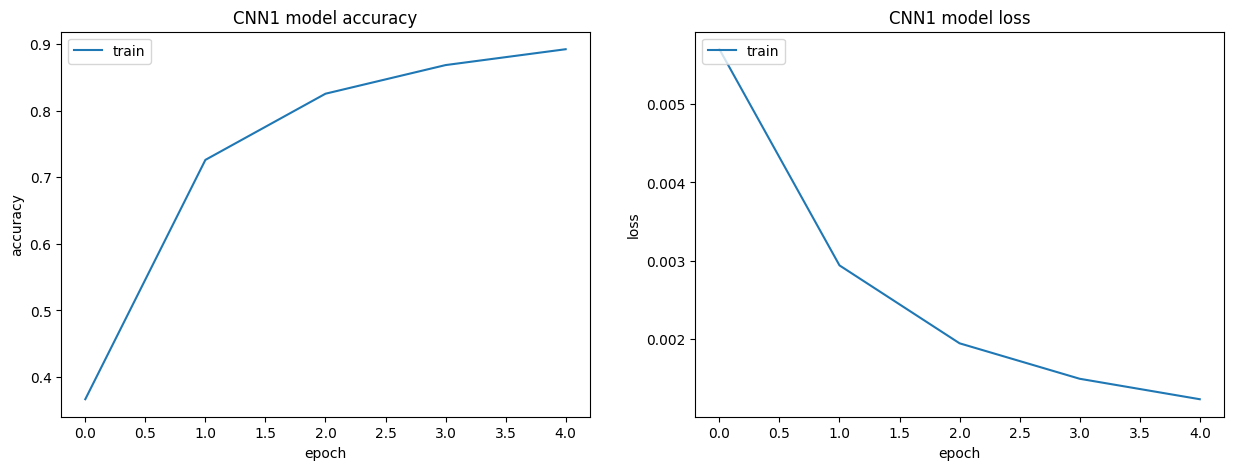

CNN2: [1.9060906171798706, 0.8090620636940002]


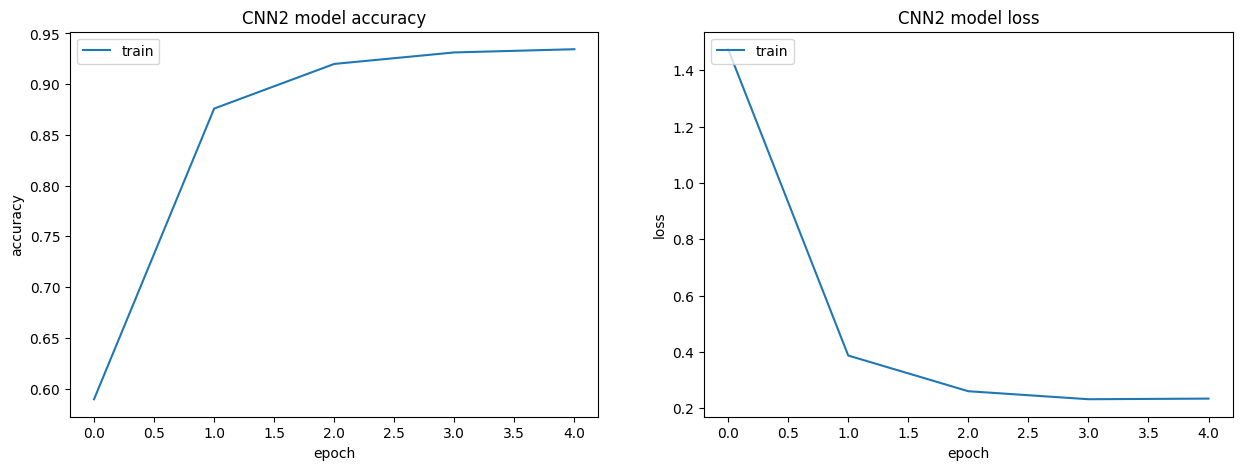

CNN3: [0.0030213515274226665, 0.7470909953117371]


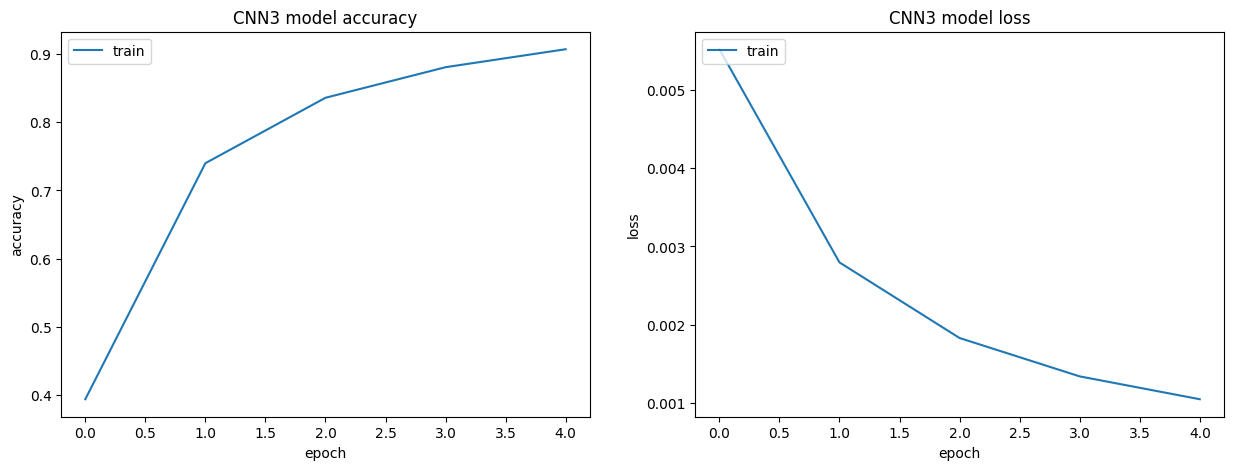

CNN4: [1.6686182022094727, 0.7953543663024902]


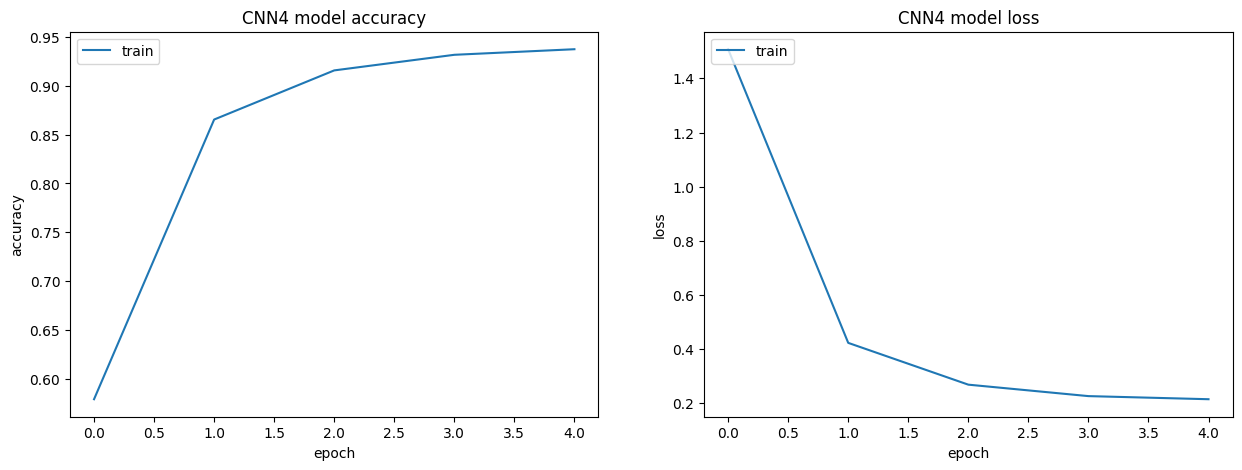

In [11]:
print('CNN1:',cnn1.evaluate(X_test,y_test_ohe,verbose=0))
areaUnderCurveGraphs(cnn1History, 'CNN1')

print('CNN2:',cnn2.evaluate(X_test,y_test_ohe,verbose=0))
areaUnderCurveGraphs(cnn2History, 'CNN2')

print('CNN3:',cnn3.evaluate(X_test,y_test_ohe,verbose=0))
areaUnderCurveGraphs(cnn3History, 'CNN3')

print('CNN4:',cnn4.evaluate(X_test,y_test_ohe,verbose=0))
areaUnderCurveGraphs(cnn4History, 'CNN4')

#### 2.4 Compare the CNN to a MLP
Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

In [17]:
%%time

# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlpHistory = mlp.fit(datagen.flow(X_train, y_train_ohe), 
        steps_per_epoch=int(len(X_train)/32), epochs=15)

Epoch 1/15
2115/2115 [==============================] - 26s 12ms/step - loss: 2.6180 - accuracy: 0.2946
Epoch 2/15
2115/2115 [==============================] - 25s 12ms/step - loss: 1.6562 - accuracy: 0.5129
Epoch 3/15
2115/2115 [==============================] - 25s 12ms/step - loss: 1.3956 - accuracy: 0.5870
Epoch 4/15
2115/2115 [==============================] - 25s 12ms/step - loss: 1.2683 - accuracy: 0.6244
Epoch 5/15
2115/2115 [==============================] - 25s 12ms/step - loss: 1.1834 - accuracy: 0.6472
Epoch 6/15
2115/2115 [==============================] - 25s 12ms/step - loss: 1.1411 - accuracy: 0.6617
Epoch 7/15
2115/2115 [==============================] - 26s 12ms/step - loss: 1.1174 - accuracy: 0.6695
Epoch 8/15
2115/2115 [==============================] - 25s 12ms/step - loss: 1.1006 - accuracy: 0.6766
Epoch 9/15
2115/2115 [==============================] - 25s 12ms/step - loss: 1.1093 - accuracy: 0.6755
Epoch 10/15
2115/2115 [==============================] - 25s 12m

In [18]:
# Increased epochs to 15
# cnn2History = cnn2.fit(datagen.flow(X_train, y_train_ohe, batch_size=32), 
#                    steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
#                    epochs=15, verbose=1,
#                    validation_data=(X_test,y_test_ohe)
#                   )

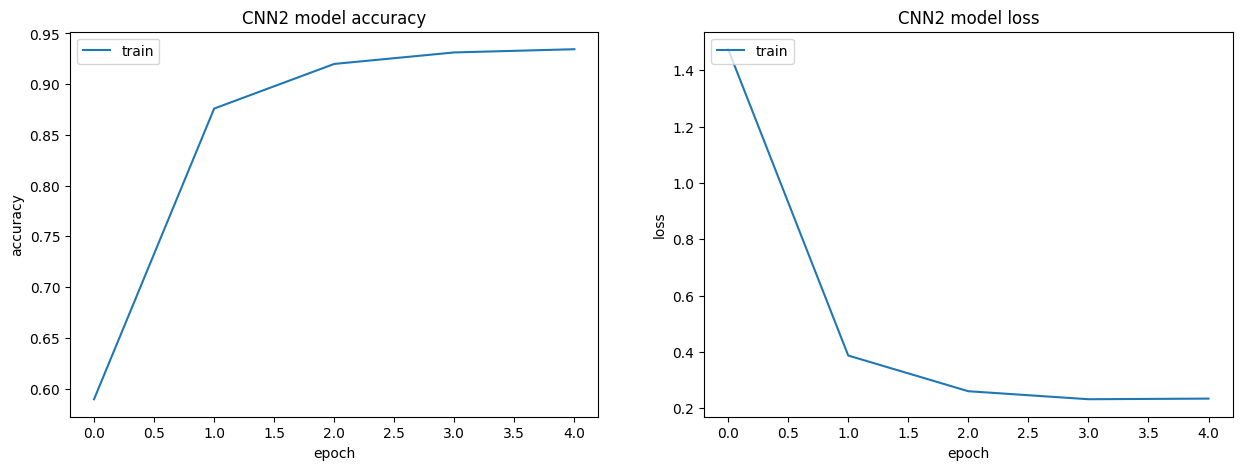

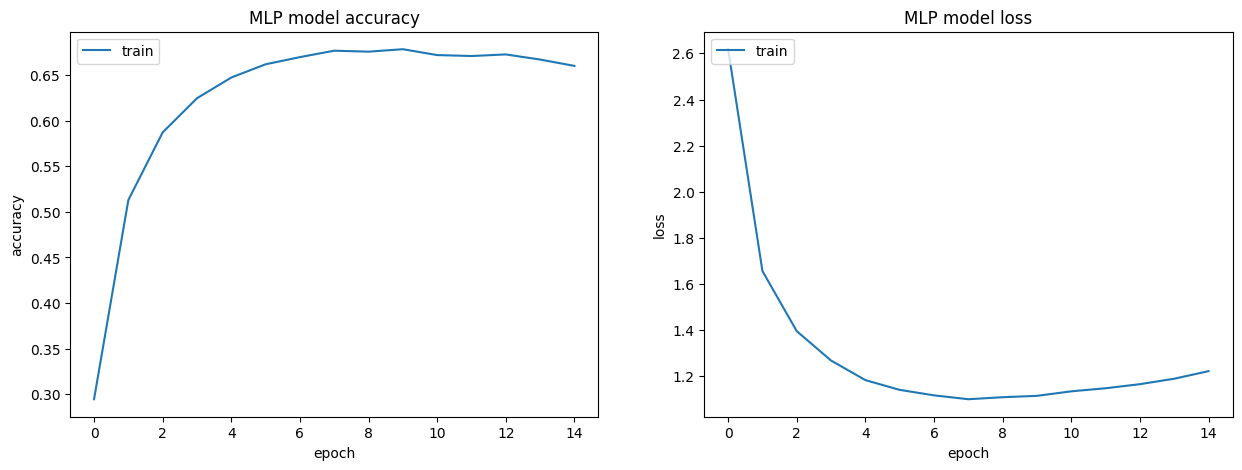

In [19]:
areaUnderCurveGraphs(cnn2History, 'CNN2')
areaUnderCurveGraphs(mlpHistory, 'MLP')

### 3. Transfer Learning to Pre-Train the Weights of your Initial Layers of your CNN
Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'fruit_dataset/train/train/',
    image_size=(100, 100),
    batch_size=32
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'fruit_dataset/test/test/',
    image_size=(100, 100),
    batch_size=32
)
data_augmentation = tf.keras.Sequential([
    # 1st transformation to augment our data
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    # 2nd transformation
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2) 
])
preprocess_input = tf.keras.applications.resnet.preprocess_input

#-----------------------------

res_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(100, 100, 3), # input shape 100 by 100 (img resolution), 3 (color channel)
    include_top=False, # disallow a fully-connected layer at the top
    weights='imagenet', # set weights equal to the weights from training on imagenet
)
res_model.trainable = False 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES)


#--------------------------------

# we will use the functional API from tensorflow as an input layer with image sizes for a shape
inputs = tf.keras.Input(shape=(100, 100, 3))
# then we use the data_augmentation layer (which in fact was 2 layers) and since its functional API it will go right through both
x = data_augmentation(inputs)
# then we will have the preprocess_input layer
x = preprocess_input(x)
# then we have our actual Base model , with parameters that are pre-trained make sure training=False (this has something to do
# with batch_normalization layers that are inside ResNet)
x = res_model(x, training=False)
# then we will run it through our Global Average Layer
x = global_average_layer(x)
# then we will give it a DropOut layer which will randomly select parameters to not be trained during different iterations
x = tf.keras.layers.Dropout(0.2)(x) # with a dropout of 20%
# finally our outputs which will be the prediction layer we created
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='rmsprop',
    # we don't have an activation 'softmax' on the output layer so we specify "from_logits=True" on the loss function
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'] 
)
model.summary()

#------------------------------------------------------


history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Found 67692 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.
94765736/94765736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 100, 100, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                        